## Step 4: Model Training and Evaluation

We will train regression and classification models to predict the next day's AQI value and AQI category using our engineered features.


In [1]:
# load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/final_dataset.csv')
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,pm10,so2,co,o3,no2,max,tempmax,tempmin,temp,...,is_weekend,aqi_lag1,tempmax_lag1,humidity_lag1,aqi_lag3,rolling_aqi_3,rolling_tempmax_3,tempmax_x_humidity,wind_x_cloud,tempmax_category
0,2016-01-01,72.0,32.0,53.0,51.0,11.0,72.0,32.39,24.00,28.17,...,False,NaN,NaN,NaN,NaN,NaN,NaN,2630.068,843.90,Hot
1,2016-01-02,52.0,32.0,29.0,50.0,12.0,52.0,31.72,24.89,27.17,...,True,72.0,32.39,81.2,NaN,NaN,NaN,2715.232,1203.60,Hot
2,2016-01-03,44.0,33.0,33.0,50.0,18.0,50.0,32.72,25.00,28.39,...,True,52.0,31.72,85.6,NaN,58.000000,32.276667,2588.152,629.37,Hot
3,2016-01-04,61.0,33.0,36.0,103.0,24.0,103.0,31.72,26.00,28.56,...,False,50.0,32.72,79.1,72.0,68.333333,32.053333,2566.148,482.04,Hot
4,2016-01-05,99.0,33.0,54.0,67.0,22.0,99.0,32.39,25.17,28.56,...,False,103.0,31.72,80.9,52.0,84.000000,32.276667,2610.634,672.60,Hot


### 1. Prepare Input Features and Target Columns

We select the columns that will be used for training. We also drop rows with missing target values (usually due to shifting or rolling).


In [2]:
# drop rows where either target is missing
df = df.dropna(subset=['next_day_aqi', 'aqi_category'])

# check remaining row count
print(f"Remaining rows: {len(df)}")

Remaining rows: 2048


In [3]:
# choose input features 
features = [
    'tempmax', 'humidity', 'windspeed', 'cloudcover',
    'month', 'dayofweek', 'is_weekend',
    'aqi_lag1', 'aqi_lag3', 'rolling_aqi_3',
    'tempmax_x_humidity', 'wind_x_cloud'
]

# input data (X)
X = df[features]

# regression target data (y)
y_reg = df['next_day_aqi']

# classification target data (y)
y_clf = df['aqi_category']


### 2. Train-Test Split

We split the dataset into training and testing sets.
- 80% for training
- 20% for testing
We will do it once for regression, and once for classification.

In [4]:
from sklearn.model_selection import train_test_split

# regression split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# classification split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

### 3. Train Regression Model

We use RandomForestRegressor to predict the next day’s AQI value.


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# train regression model
reg_model = RandomForestRegressor(random_state=42)
reg_model.fit(X_train_reg, y_train_reg)

# predict on test set
y_pred_reg = reg_model.predict(X_test_reg)

### 4. Evaluate Regression Model


In [6]:
import numpy as np

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 22.53643902439024
RMSE: 30.351036635970914


### Interpretation of Regression Results

The regression model achieved:

- **Mean Absolute Error (MAE):** ~22.54
- **Root Mean Squared Error (RMSE):** ~30.35

These metrics indicate that the model, on average, predicts the next day's AQI within ~22 units. The RMSE is slightly higher (~30), suggesting that the model makes some larger errors occasionally, which are penalized more heavily.

Given that AQI values in Jakarta can range from below 50 to over 200, an RMSE of 30 is a reasonable starting point. However, the model can be further improved by tuning hyperparameters, testing additional models, or engineering more features.


### Visualizing Actual vs Predicted AQI (Regression)

This plot compares the model's predicted AQI values with the actual AQI values from the test set. It helps visualize how closely the model tracks real-world air quality trends.


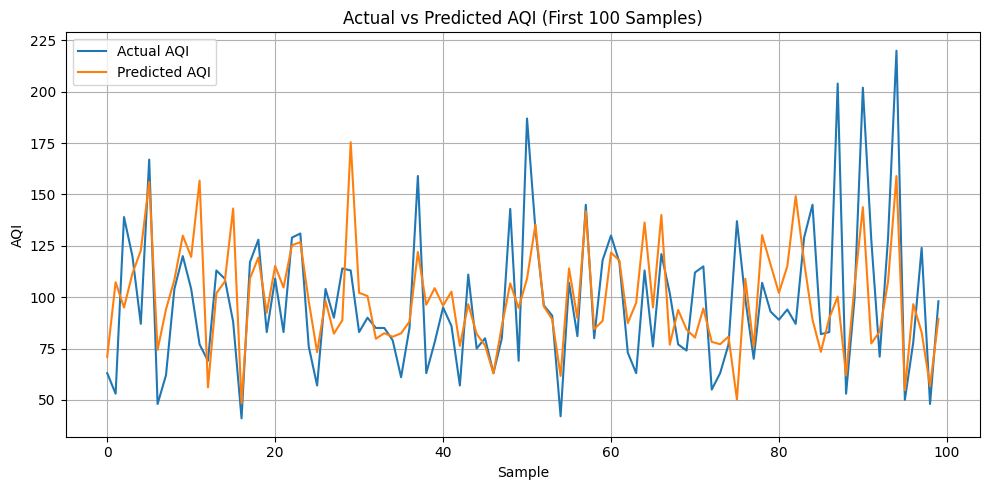

In [7]:
import matplotlib.pyplot as plt

# plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_reg.values[:100], label='Actual AQI')
plt.plot(y_pred_reg[:100], label='Predicted AQI')
plt.title("Actual vs Predicted AQI (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Feature Importance (Regression Model)

This bar chart shows which input features contributed most to the Random Forest regression model. Higher importance means the feature had more influence in determining the AQI prediction.


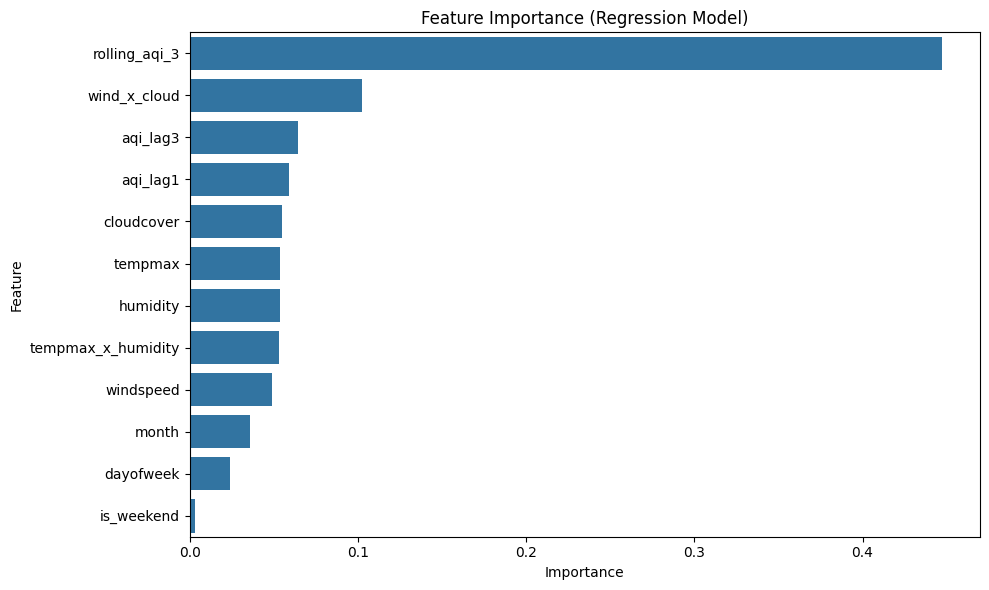

In [8]:
import seaborn as sns

importances = reg_model.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title("Feature Importance (Regression Model)")
plt.tight_layout()
plt.show()

### 5. Train Classification Model

We use RandomForestClassifier to predict AQI category (e.g., Good, Moderate, etc).


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# train classification model
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train_clf, y_train_clf)

# predict on test set
y_pred_clf = clf_model.predict(X_test_clf)

### 6. Evaluate Classification Model


In [10]:
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf)}")
print("\nclassification report:\n", classification_report(y_test_clf, y_pred_clf))
print("\nconfusion matrix:\n", confusion_matrix(y_test_clf, y_pred_clf))

Accuracy: 0.6926829268292682

classification report:
                 precision    recall  f1-score   support

          Good       0.89      0.38      0.53        21
      Moderate       0.69      0.87      0.77       225
     Unhealthy       0.68      0.53      0.60       152
Very Unhealthy       0.00      0.00      0.00        12

      accuracy                           0.69       410
     macro avg       0.56      0.45      0.47       410
  weighted avg       0.68      0.69      0.67       410


confusion matrix:
 [[  8  13   0   0]
 [  1 195  29   0]
 [  0  71  81   0]
 [  0   2  10   0]]


d:\DSA\build 2\jakarta-aqi-forecasting\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DSA\build 2\jakarta-aqi-forecasting\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\DSA\build 2\jakarta-aqi-forecasting\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

### Interpretation of Classification Results

The classification model achieved an overall accuracy of approximately **69%**, which indicates that it correctly predicted the next day's AQI category nearly 7 out of 10 times.

#### Key Observations:
- The **'Moderate'** class had the best performance, with high recall (0.87) and a solid F1-score (0.77). This is expected, as it was the most frequent class in the dataset.
- The **'Unhealthy'** class had moderate performance, with an F1-score of 0.60.
- The **'Very Unhealthy'** category was never predicted by the model (precision, recall, and F1-score were 0.00). This is likely due to the small number of samples in this class (only 12), making it difficult for the model to learn to predict it.

The confusion matrix shows that most errors come from misclassifying **'Good'** and **'Unhealthy'** as **'Moderate'**, which reflects the class imbalance in the dataset. Improving performance may require:
- Adding more data, especially for rare categories
- Using sampling techniques (e.g., SMOTE, class weighting)
- Trying different models (e.g., Gradient Boosting, XGBoost)

Despite this, the model performs reasonably well and provides a good starting point for AQI category forecasting.


### Feature Importance (Classification Model)

This plot shows which input features contributed most to the Random Forest classification model. Features with higher importance had more influence in determining the predicted AQI category.


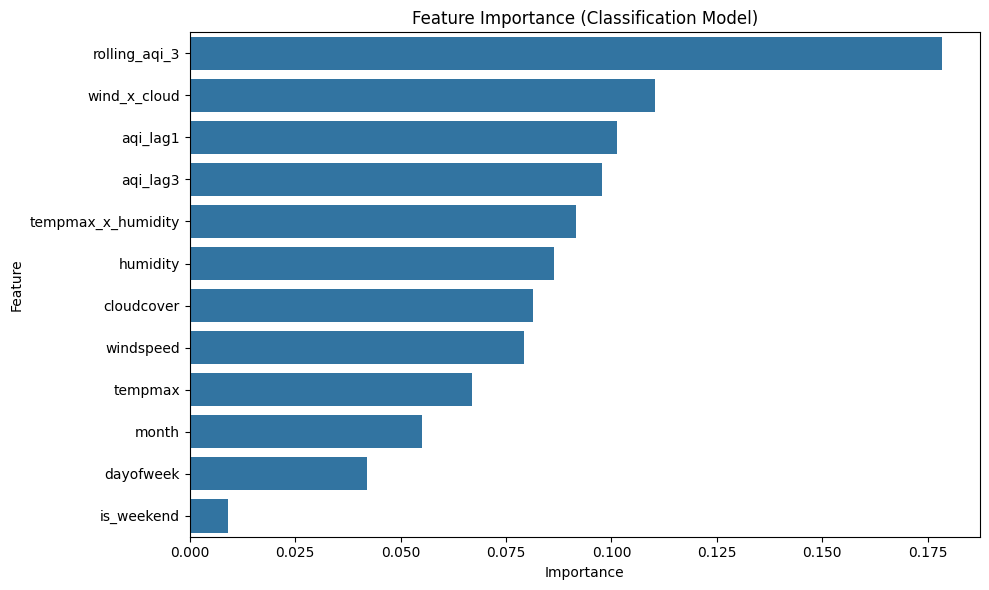

In [11]:
importances_clf = clf_model.feature_importances_
feature_names = X.columns

# create dataframe
fi_df_clf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_clf
}).sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df_clf)
plt.title("Feature Importance (Classification Model)")
plt.tight_layout()
plt.show()

## Final Thoughts

This concludes the AQI forecasting project. The models built using Random Forest showed good performance for both regression and classification tasks, with rolling AQI features and weather data playing key roles. Future work could involve model tuning, time-series cross-validation, or using deep learning models for temporal sequences.
